In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [0]:
# Load the CSV File created by the previous notebook
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id_df_fe = '1hJJA8WXEFB9__8CzotLiaVAhb8owNXZ9'
id_train = '1CdbudO8YIOaVfnm4XrsS1pa28D_cHrXw'
id_nlp = '13Prkiot-joAo4E4uEqn0_HPpZCYfjqdS'

id_final_feature_test = '1-qzonX_xQ0zpaBn-6kyi0s-mn9RfBzAX'
id_final_feature_w2v_test = '1-CzvkjvE-qGb-U__qrq82ITKMRS67GO3'

id_y_train = '1-cvHsGn_LnBEuuJ2Wz4Us6WN5kJ1-jld'
id_y_test = '1-e9SIPKxzdy1cY6vVgfK93JxaA3a6Je9'

downloaded = drive.CreateFile({'id':id_train})
downloaded2 = drive.CreateFile({'id':id_df_fe})
downloaded3 = drive.CreateFile({'id':id_nlp})

downloaded4 = drive.CreateFile({'id':id_final_feature_test})
downloaded6 = drive.CreateFile({'id':id_final_feature_w2v_test})

downloaded8 = drive.CreateFile({'id':id_y_train})
downloaded9 = drive.CreateFile({'id':id_y_test})

downloaded.GetContentFile('train.csv')
downloaded2.GetContentFile('df_fe_without_preprocessing_train_quora.csv')
downloaded3.GetContentFile('nlp_features_train_quora.csv')
downloaded6.GetContentFile('final_features_quora_w2v_test.csv')

In [0]:
id_final_feature_w2v_train = '1-tlvUpLkHt9o3kcILh8QtrgyhObpcP_l'
downloaded7 = drive.CreateFile({'id':id_final_feature_w2v_train})
downloaded7.GetContentFile('final_features_quora_w2v_train1.csv')

In [0]:
id_final_feature_train = '1--RoMw9KKTOATKYwK3EJaOk_RCZkevdG'
downloaded5 = drive.CreateFile({'id':id_final_feature_train})
downloaded5.GetContentFile('final_features_train11.npz')

In [0]:
id_final_feature_test = '1-EseFoExM10DLCZV2M8btWITm4K-t3dI'
downloaded4 = drive.CreateFile({'id':id_final_feature_test})
downloaded4.GetContentFile('final_features_test11.npz')

In [0]:
id_y_train = '1-G8MD9EneuViL0jNDn7gf31n05W_tgY8'
downloaded8 = drive.CreateFile({'id':id_y_train})
downloaded8.GetContentFile('Y_tfidf_train1.csv')

In [0]:
id_y_test = '1-Leui9kK2IY_4r8brZtnmHofEnx0AhnL'
downloaded9 = drive.CreateFile({'id':id_y_test})
downloaded9.GetContentFile('Y_tfidf_test1.csv')

<h1>4. Machine Learning Models </h1>

**4.1 : LOGISTIC REGRESSION AND LINEAR SVM MODELS**

***Loading the data from .npz file for Logistic Regression and Linear SVM Model building : ***


In [0]:
import scipy.sparse
X_Train = scipy.sparse.load_npz('final_features_train11.npz')

In [0]:
X_Train.shape

(283003, 24201)

In [0]:
X_Test = scipy.sparse.load_npz('final_features_test11.npz')
X_Test.shape

(121287, 24201)

In [0]:
Y_Train = pd.read_csv('Y_tfidf_train1.csv',header = None,usecols=[1])
Y_Test = pd.read_csv('Y_tfidf_test1.csv',header = None,usecols=[1])

In [0]:
print(Y_Train.shape)
print(Y_Test.shape)

(283003, 1)
(121287, 1)


In [0]:
Y_Train.head()

,1
0,1
1,0
2,0
3,1
4,0


***Loading the TFIDF_W2V vectored features from .csv file for XGBOOST Training***

In [0]:
X_Train_w2v = pd.read_csv("final_features_quora_w2v_train1.csv")
X_Train_w2v.shape

(283003, 222)

In [0]:
X_Train_w2v.head(2)

,Unnamed: 0,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,is_duplicate,is_duplicate.1,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,82817,4,2,34,43,7,8,5.0,15.0,0.333333,6,2,0.999900,0.499975,0.799984,0.666656,0.714276,0.714276,0.0,0.0,0.0,7.0,88,71,80,85,0.771429,0,0,7.090451,-1.862659,-49.456611,-56.283810,-51.790498,63.632962,-5.295274,33.157303,2.342729,-2.263824,...,38.776590,-33.523294,-39.500026,39.272362,-50.031311,8.778709,45.040307,-52.857321,21.911999,19.666619,38.122326,75.046336,-12.856911,-29.398831,34.125122,-45.786491,-0.182641,76.021515,-31.316083,8.629522,-27.158724,-23.636512,-9.718953,-9.690776,4.183228,28.652466,-65.830930,54.284922,16.298943,-57.916700,33.691885,-47.942557,29.853445,2.017321,-5.660319,-14.542119,29.515649,-5.933426,-8.200077,41.193522
1,1,46503,1,1,87,105,19,19,4.0,35.0,0.114286,2,0,0.399996,0.399996,0.333328,0.222220,0.315788,0.285713,0.0,0.0,2.0,20.0,65,66,51,54,0.181818,0,0,236.278434,-12.043294,-155.940614,-203.949228,2.923514,185.491072,27.326979,28.423408,-20.265133,221.221346,...,-68.270452,100.705458,-224.140924,-18.057727,-104.662768,-198.099155,-35.269101,-98.383430,-217.400657,72.699174,149.524094,-47.302379,-249.560254,108.584419,248.776134,-143.598504,155.502118,163.948656,171.100388,40.100747,50.388014,-129.536353,-82.574858,-162.977166,-200.453017,-107.973780,-140.235583,66.276908,43.240257,-71.820817,189.487212,-169.385001,125.681656,-43.487759,-32.775444,-22.902526,23.071059,34.148737,-180.392371,206.077933


In [0]:
X_Train_w2v.drop(X_Train_w2v.index[0], inplace=True)
y_train = X_Train_w2v['is_duplicate']
X_Train_w2v.drop(['Unnamed: 0', 'id','is_duplicate','is_duplicate.1'], axis=1, inplace=True)

In [0]:
X_Train_w2v.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,1,1,87,105,19,19,4.0,35.0,0.114286,2,0,0.399996,0.399996,0.333328,0.222220,0.315788,0.285713,0.0,0.0,2.0,20.0,65,66,51,54,0.181818,236.278434,-12.043294,-155.940614,-203.949228,2.923514,185.491072,27.326979,28.423408,-20.265133,221.221346,-106.665475,130.085091,-282.444204,-156.905651,...,-68.270452,100.705458,-224.140924,-18.057727,-104.662768,-198.099155,-35.269101,-98.383430,-217.400657,72.699174,149.524094,-47.302379,-249.560254,108.584419,248.776134,-143.598504,155.502118,163.948656,171.100388,40.100747,50.388014,-129.536353,-82.574858,-162.977166,-200.453017,-107.973780,-140.235583,66.276908,43.240257,-71.820817,189.487212,-169.385001,125.681656,-43.487759,-32.775444,-22.902526,23.071059,34.148737,-180.392371,206.077933
2,2,1,40,78,9,18,2.0,26.0,0.076923,3,1,0.333328,0.222220,0.249994,0.124998,0.299997,0.166666,0.0,0.0,8.0,14.0,49,48,36,54,0.238095,106.057938,-35.983093,-45.214619,-28.717605,-44.609235,74.218300,91.006385,95.341848,-48.859206,83.919065,-49.138641,20.494593,-25.399958,-49.455079,...,55.225896,-66.483625,-179.061102,93.143486,-16.915220,-108.524252,38.104137,-25.633696,2.300996,8.991363,56.739388,61.029880,-59.046465,37.559239,84.384371,-108.341624,-2.435968,220.982588,-15.215019,27.301602,-81.944091,-131.724707,-71.210127,-22.778682,24.968607,-28.343796,-181.239910,47.742126,34.435675,-50.472899,66.792588,-130.085690,56.317126,29.127344,-24.971610,-42.849751,91.336853,15.399821,-26.015761,33.232691


In [0]:
X_Test_w2v = pd.read_csv("final_features_quora_w2v_test.csv")
X_Test_w2v.shape

(121287, 221)

In [0]:
X_Test_w2v.head(2)

,Unnamed: 0,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,is_duplicate,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,367687,1,1,49,70,11,15,5.0,22.0,0.227273,2,0,0.799984,0.799984,0.599988,0.428565,0.636358,0.466664,0.0,0.0,4.0,13.0,78,69,55,63,0.340000,0,115.762490,-74.208016,-55.801146,-101.851861,3.075431,-14.421755,42.387522,-22.599854,-21.790135,115.961914,1.999526,...,-42.050336,-33.474887,-128.849563,-34.446405,-53.191685,-189.758148,117.798423,-27.428825,-140.840117,111.528942,30.514188,-10.811285,-46.445400,64.471699,43.933532,-121.950046,148.121045,57.409255,-50.875158,107.591816,108.852331,-117.175637,-129.925104,-208.897631,-90.023910,-59.831604,-39.348337,8.588068,149.002959,-20.625835,49.385490,-32.689386,58.150453,-66.84766,-62.089226,122.674473,-48.233593,43.498084,-111.942048,53.880565
1,1,323231,1,1,169,45,27,8,4.0,32.0,0.125000,2,0,0.249994,0.071428,0.749981,0.299997,0.499994,0.148148,0.0,0.0,19.0,17.5,67,37,30,67,0.217391,0,-149.229956,-56.839321,-266.568144,-357.284265,76.632574,242.508771,497.806480,111.412513,69.693705,5.337946,-105.328928,...,17.451739,-62.360937,-61.133815,124.617794,-35.317108,4.815766,142.150825,-91.316613,42.062603,44.234816,13.178004,66.292820,-12.814468,132.130166,92.724102,-110.298620,-32.647367,93.403845,32.270570,68.259275,-19.190544,-56.931385,-27.851123,-61.624805,-0.497546,-66.170128,-137.299830,61.841954,27.854008,-12.460336,72.404718,-53.841319,69.895342,19.37914,0.380617,63.147189,-15.601520,-39.969135,-42.379380,80.420763


In [0]:

X_Test_w2v.drop(X_Test_w2v.index[0], inplace=True)
y_test = X_Test_w2v['is_duplicate']
X_Test_w2v.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [0]:
y_train.shape

(283002,)

In [0]:
y_test.shape

(121286,)

In [0]:
X_Test_w2v.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,1,1,169,45,27,8,4.0,32.0,0.125000,2,0,0.249994,0.071428,0.749981,0.299997,0.499994,0.148148,0.0,0.0,19.0,17.5,67,37,30,67,0.217391,-149.229956,-56.839321,-266.568144,-357.284265,76.632574,242.508771,497.806480,111.412513,69.693705,5.337946,-105.328928,-4.362133,-165.641075,-269.083467,...,17.451739,-62.360937,-61.133815,124.617794,-35.317108,4.815766,142.150825,-91.316613,42.062603,44.234816,13.178004,66.292820,-12.814468,132.130166,92.724102,-110.298620,-32.647367,93.403845,32.270570,68.259275,-19.190544,-56.931385,-27.851123,-61.624805,-0.497546,-66.170128,-137.299830,61.841954,27.854008,-12.460336,72.404718,-53.841319,69.895342,19.379140,0.380617,63.147189,-15.60152,-39.969135,-42.379380,80.420763
2,2,1,59,54,12,11,6.0,21.0,0.285714,3,1,0.499988,0.399992,0.666656,0.666656,0.545450,0.499996,0.0,1.0,1.0,11.5,73,65,74,72,0.309091,-19.861349,54.667933,-108.716193,-98.998296,-94.545552,33.665495,68.526613,179.496340,-2.878464,29.023105,-1.501863,54.366983,-28.829090,-7.537592,...,-12.175618,31.081464,-51.985412,66.659920,9.014578,21.782908,11.389249,-13.597135,36.497915,29.086805,61.536826,45.982179,-9.341120,0.835339,-37.119598,-41.431695,-62.840341,29.551212,11.334541,42.941619,56.473365,-6.503847,-1.145227,57.446419,26.180955,-68.277913,-35.852239,80.342277,-37.397508,-39.666340,57.182267,-3.590208,29.605132,98.324125,21.729881,-9.050531,32.06649,14.101288,5.091188,-3.974192


In [0]:
print("Number of data points in train data :",X_Train_w2v.shape)
print("Number of data points in test data :",X_Test_w2v.shape)

Number of data points in train data : (283002, 218)
Number of data points in test data : (121286, 218)


***Checking the distributions of the target varibles***

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307998911664623 Class 1:  0.3692001088335377
---------- Distribution of output variable in train data ----------
Class 0:  0.36920172155071485 Class 1:  0.36920172155071485


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8900509394363698


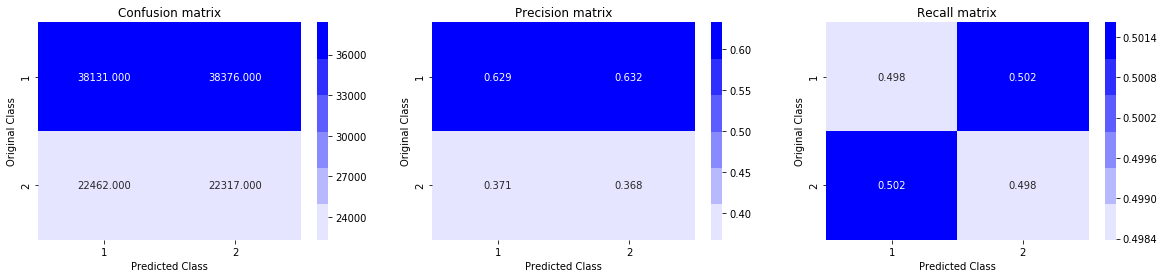

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.37707722881123173
For values of alpha =  0.0001 The log loss is: 0.3834269130579413
For values of alpha =  0.001 The log loss is: 0.4137694076840119
For values of alpha =  0.01 The log loss is: 0.4454469442312907
For values of alpha =  0.1 The log loss is: 0.4595510258228528
For values of alpha =  1 The log loss is: 0.48974742506604835
For values of alpha =  10 The log loss is: 0.5401734300243908


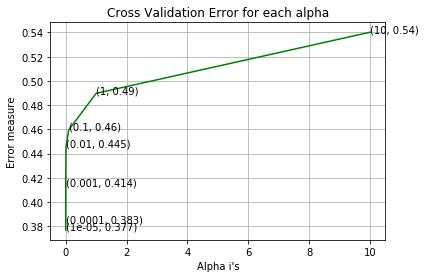

For values of best alpha =  1e-05 The train log loss is: 0.3733759232189838
For values of best alpha =  1e-05 The test log loss is: 0.37707722881123173
Total number of data points : 121287


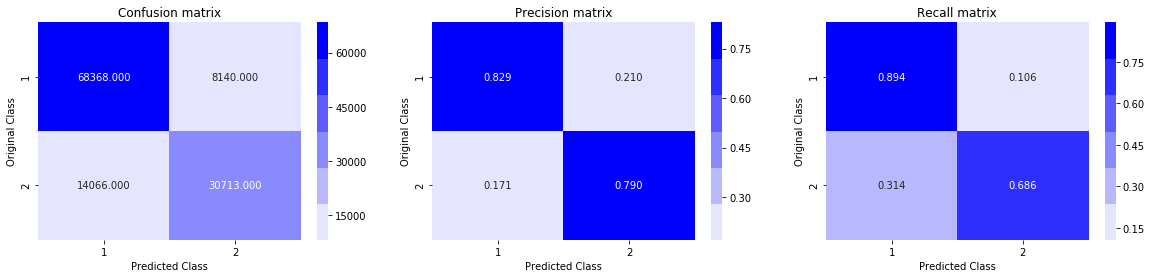

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train, Y_Train)
    predict_y = sig_clf.predict_proba(X_Test)
    log_error_array.append(log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train, Y_Train)

predict_y = sig_clf.predict_proba(X_Train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_Test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.42154855032746996
For values of alpha =  0.0001 The log loss is: 0.44584133399481124
For values of alpha =  0.001 The log loss is: 0.45920423301200636
For values of alpha =  0.01 The log loss is: 0.4934548517649804
For values of alpha =  0.1 The log loss is: 0.4850642357808225
For values of alpha =  1 The log loss is: 0.5802162819966458
For values of alpha =  10 The log loss is: 0.6266773106468647


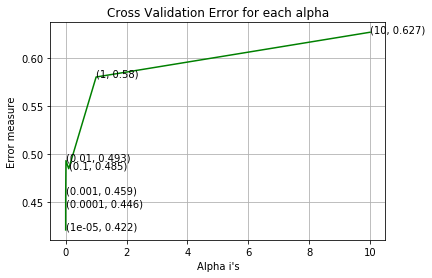

For values of best alpha =  1e-05 The train log loss is: 0.41903703204023746
For values of best alpha =  1e-05 The test log loss is: 0.42154855032746996
Total number of data points : 121287


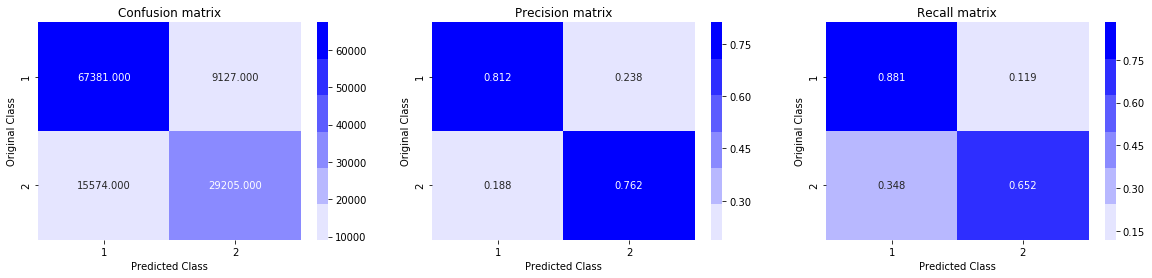

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_Train, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train, Y_Train)
    predict_y = sig_clf.predict_proba(X_Test)
    log_error_array.append(log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_Train, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train, Y_Train)

predict_y = sig_clf.predict_proba(X_Train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_Test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [0]:
tuned_param = dict({'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
               'n_estimators' : [5, 10, 50, 100, 200, 500],
               })

In [0]:
import xgboost as xgb 
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV

xgb = xgb.XGBClassifier(random_state = 7, verbosity = 3,gamma = 0.5,learning_rate = 0.02)
tfidf_w2v_model = RandomizedSearchCV(estimator = xgb,param_distributions = tuned_param,cv = 3, scoring = 'neg_log_loss', verbose = 20, return_train_score = True)
tfidf_w2v_model.fit(X_Train_w2v,y_train)

print("CV RESULTS : ",tfidf_w2v_model.cv_results_)
print("BEST ESTIMATOR : ",tfidf_w2v_model.best_estimator_)

predict_y = tfidf_w2v_model.predict(X_Test_w2v)
#print("The test log loss is:",log_loss(y_test, predict_y, labels=[2,], eps=1e-15))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=5, max_depth=8 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19:19:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 12 pruned nodes, max_depth=8
[19:19:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 4 pruned nodes, max_depth=8
[19:19:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 4 pruned nodes, max_depth=8
[19:19:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 6 pruned nodes, max_depth=8
[19:19:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 10 pruned nodes, max_depth=8
[CV]  n_estimators=5, max_depth=8, score=(train=-0.647, test=-0.647), total=  45.6s
[19:19:47] ======== Monitor: Learner ========
[19:19:47] GetGradient: 0.0713697s, 5 calls @ 14273us
[19:19:47] PredictRaw: 0.176655s, 5 calls @ 35330us
[19:19:47] UpdateOneIter: 44.1389s, 5 calls @ 8827785us
[19:19:47] ======== Monitor: GBTree ========
[19:19:47] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.4s remaining:    0.0s


[19:20:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 2 pruned nodes, max_depth=8
[19:20:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 8 pruned nodes, max_depth=8
[19:20:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 6 pruned nodes, max_depth=8
[19:20:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 4 pruned nodes, max_depth=8
[19:20:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 6 pruned nodes, max_depth=8
[CV]  n_estimators=5, max_depth=8, score=(train=-0.647, test=-0.647), total=  44.8s
[19:20:32] ======== Monitor: Learner ========
[19:20:32] GetGradient: 0.0692652s, 5 calls @ 13853us
[19:20:32] PredictRaw: 0.172734s, 5 calls @ 34546us
[19:20:32] UpdateOneIter: 43.8079s, 5 calls @ 8761581us
[19:20:32] ======== Monitor: GBTree ========
[19:20:32] Bo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[19:20:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 12 pruned nodes, max_depth=8
[19:20:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 12 pruned nodes, max_depth=8
[19:21:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 8 pruned nodes, max_depth=8
[19:21:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 10 pruned nodes, max_depth=8
[19:21:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 6 pruned nodes, max_depth=8
[CV]  n_estimators=5, max_depth=8, score=(train=-0.647, test=-0.648), total=  44.8s
[19:21:18] ======== Monitor: Learner ========
[19:21:18] GetGradient: 0.0666574s, 5 calls @ 13331us
[19:21:18] PredictRaw: 0.173851s, 5 calls @ 34770us
[19:21:18] UpdateOneIter: 43.8448s, 5 calls @ 8768961us
[19:21:18] ======== Monitor: GBTree ========
[19:21:18]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[19:21:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 8 pruned nodes, max_depth=7
[19:21:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[19:21:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 4 pruned nodes, max_depth=7
[19:21:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[19:21:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:22:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=7
[19:22:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:22:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 e

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.1min remaining:    0.0s


[19:27:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[19:27:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:27:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[19:27:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=7
[19:27:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 2 pruned nodes, max_depth=7
[19:27:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:27:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[19:28:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 e

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.9min remaining:    0.0s


[19:33:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 6 pruned nodes, max_depth=7
[19:33:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 6 pruned nodes, max_depth=7
[19:33:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 4 pruned nodes, max_depth=7
[19:33:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 4 pruned nodes, max_depth=7
[19:33:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 4 pruned nodes, max_depth=7
[19:33:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 4 pruned nodes, max_depth=7
[19:33:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 4 pruned nodes, max_depth=7
[19:33:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 e

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 19.6min remaining:    0.0s


[19:38:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 8 pruned nodes, max_depth=7
[19:38:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[19:39:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 4 pruned nodes, max_depth=7
[19:39:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[19:39:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:39:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=7
[19:39:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:39:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 e

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 31.1min remaining:    0.0s


[19:50:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[19:50:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:50:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[19:50:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=7
[19:50:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 2 pruned nodes, max_depth=7
[19:50:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[19:50:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[19:51:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 e

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 43.5min remaining:    0.0s


[20:02:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 6 pruned nodes, max_depth=7
[20:02:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 6 pruned nodes, max_depth=7
[20:02:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 4 pruned nodes, max_depth=7
[20:03:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 4 pruned nodes, max_depth=7
[20:03:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 4 pruned nodes, max_depth=7
[20:03:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 4 pruned nodes, max_depth=7
[20:03:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 4 pruned nodes, max_depth=7
[20:03:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 e

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 56.5min remaining:    0.0s


[20:15:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:15:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pr

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 58.2min remaining:    0.0s


[20:17:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:27] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:17:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pr

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 60.0min remaining:    0.0s


[20:19:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[20:19:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pr

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 61.7min remaining:    0.0s


[20:20:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1228 extra nodes, 24 pruned nodes, max_depth=10
[20:21:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1206 extra nodes, 10 pruned nodes, max_depth=10
[20:21:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1206 extra nodes, 12 pruned nodes, max_depth=10
[20:21:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1202 extra nodes, 26 pruned nodes, max_depth=10
[20:21:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1236 extra nodes, 16 pruned nodes, max_depth=10
[20:21:48] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1196 extra nodes, 20 pruned nodes, max_depth=10
[20:21:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1208 extra nodes, 26 pruned nodes, max_depth=10
[20:22:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree prunin

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 70.3min remaining:    0.0s


[20:29:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1192 extra nodes, 24 pruned nodes, max_depth=10
[20:29:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 28 pruned nodes, max_depth=10
[20:29:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1184 extra nodes, 20 pruned nodes, max_depth=10
[20:30:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1204 extra nodes, 30 pruned nodes, max_depth=10
[20:30:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 24 pruned nodes, max_depth=10
[20:30:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 36 pruned nodes, max_depth=10
[20:30:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1220 extra nodes, 30 pruned nodes, max_depth=10
[20:30:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree prunin

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 78.7min remaining:    0.0s


[20:37:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1184 extra nodes, 40 pruned nodes, max_depth=10
[20:38:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1174 extra nodes, 14 pruned nodes, max_depth=10
[20:38:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1180 extra nodes, 20 pruned nodes, max_depth=10
[20:38:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 28 pruned nodes, max_depth=10
[20:38:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 28 pruned nodes, max_depth=10
[20:38:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 36 pruned nodes, max_depth=10
[20:39:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 28 pruned nodes, max_depth=10
[20:39:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree prunin

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 87.5min remaining:    0.0s


[20:46:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 12 pruned nodes, max_depth=9
[20:46:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 750 extra nodes, 4 pruned nodes, max_depth=9
[20:46:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 6 pruned nodes, max_depth=9
[20:47:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 6 pruned nodes, max_depth=9
[20:47:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 10 pruned nodes, max_depth=9
[20:47:25] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 14 pruned nodes, max_depth=9
[20:47:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 764 extra nodes, 6 pruned nodes, max_depth=9
[20:47:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 102.9min remaining:    0.0s


[21:02:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 10 pruned nodes, max_depth=9
[21:02:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 20 pruned nodes, max_depth=9
[21:02:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 12 pruned nodes, max_depth=9
[21:02:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 18 pruned nodes, max_depth=9
[21:02:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 12 pruned nodes, max_depth=9
[21:02:53] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 18 pruned nodes, max_depth=9
[21:03:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 14 pruned nodes, max_depth=9
[21:03:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 118.1min remaining:    0.0s


[21:17:20] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 20 pruned nodes, max_depth=9
[21:17:28] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 752 extra nodes, 8 pruned nodes, max_depth=9
[21:17:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 14 pruned nodes, max_depth=9
[21:17:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 16 pruned nodes, max_depth=9
[21:17:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 16 pruned nodes, max_depth=9
[21:18:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 22 pruned nodes, max_depth=9
[21:18:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 14 pruned nodes, max_depth=9
[21:18:21] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 135.0min remaining:    0.0s


[21:34:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 8 pruned nodes, max_depth=7
[21:34:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[21:34:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 4 pruned nodes, max_depth=7
[21:34:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[21:34:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[CV]  n_estimators=5, max_depth=7, score=(train=-0.648, test=-0.648), total=  37.7s
[21:34:38] ======== Monitor: Learner ========
[21:34:38] GetGradient: 0.0630432s, 5 calls @ 12608us
[21:34:38] PredictRaw: 0.157689s, 5 calls @ 31537us
[21:34:38] UpdateOneIter: 36.3582s, 5 calls @ 7271639us
[21:34:38] ======== Monitor: GBTree ========
[21:34:38] Bo

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 135.6min remaining:    0.0s


[21:34:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[21:34:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=7
[21:35:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[21:35:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=7
[21:35:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 2 pruned nodes, max_depth=7
[CV]  n_estimators=5, max_depth=7, score=(train=-0.648, test=-0.648), total=  37.6s
[21:35:16] ======== Monitor: Learner ========
[21:35:16] GetGradient: 0.0649974s, 5 calls @ 12999us
[21:35:16] PredictRaw: 0.158237s, 5 calls @ 31647us
[21:35:16] UpdateOneIter: 36.6946s, 5 calls @ 7338922us
[21:35:16] ======== Monitor: GBTree ========
[21:35:16] Bo

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 387.6min finished


[01:46:58] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 6 pruned nodes, max_depth=7
[01:47:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[01:47:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[01:47:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 6 pruned nodes, max_depth=7
[01:47:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 4 pruned nodes, max_depth=7
[01:47:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 4 pruned nodes, max_depth=7
[01:47:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 2 pruned nodes, max_depth=7
[01:48:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 e

ValueError: ignored

In [0]:
print("Test Score : ", tfidf_w2v_model.score(X_Test_w2v,y_test) )

Test Score :  -0.32801646560190384


Total number of data points : 121286


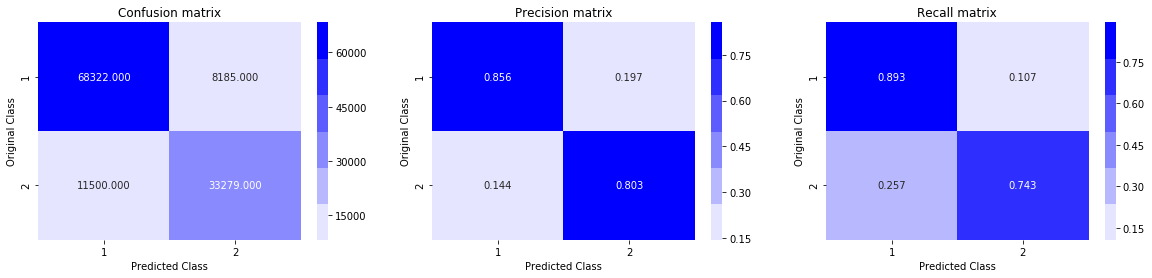

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**<h1> 5. CONCLUSIONS : </h1>**

In [4]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Test Loss"]
x.add_row([ 'Logistic Regression with TFIDF features' ,0.37])
x.add_row([ 'SVM with TFIDF Features',0.42])
x.add_row([ 'XGBoost with GLOVE Features',0.32])
print(x)

+-----------------------------------------+-----------+
|                  Model                  | Test Loss |
+-----------------------------------------+-----------+
| Logistic Regression with TFIDF features |    0.37   |
|         SVM with TFIDF Features         |    0.42   |
|       XGBoost with GLOVE Features       |    0.32   |
+-----------------------------------------+-----------+


***PROCEDURE :*** 

Before preprocessing we created some basic features. After preprocessing and cleaning , we created some extra advanced fuzzywuzzy features. Then we split the data into 70:30 ratio in Train and Test Set.

Part 1: We used TFIDF vectorizer on Question 1 anjd Question 2 features. As a result we got a sparse matrix that we concatenated with other NLP + Preproccessed features features to create a sparse matrix of features. We saved these feature matrix for further use in a .npz file. In this notebook, we loaded that feature matrix (.npz file)  and applied Logistic Regression and Linear SVM on it. 

Part 2: We used GLOVE featurization on  Question 1 and Question 2 features. We saved the final features created through Glove featurization in a csv file. In this notebook, we loaded that feature matrix (.npz file)  and applied XGBoost algorithm on it.  